# 1. Colab 환경 설정

####실행에 필요한 라이브러리와 KoBERT 모델을 불러온다

In [ ]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

#Kobert 파일 로드 from github
!pip install git+https://github.com/Jsgithubchannel/KoBERT.git@master

#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     |████████████████████████████████| 47.3 MB 19.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.4 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595731 sha256=d7b6bf3a9e4155ec44a6f3dd1c68f3d46f9f1b0ba2ad0a407f44e71813339738
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 3.3 MB 45.5 MB/s 
     |████████████████████████████████| 61 kB 473 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13

####필요한 모듈을 import

In [ ]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm import tqdm, notebook
import random

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

####구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/capstone_design/

# 2. 데이터셋 전처리

####구글 드라이브에서 데이터 파일 읽어오기

In [ ]:
test_data = pd.read_excel('웰니스_대화_스크립트_데이터셋.xlsx')

####사용자 말 데이터만 뽑기

In [ ]:
wellness_dialog_human = []

for emo, sen in zip(test_data['구분'], test_data['유저']):
  data = []
  data.append(emo)
  data.append(sen)

  wellness_dialog_human.append(data)

wellness_dialog_human[0:5]

[['감정/감정조절이상', '제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.'],
 ['감정/감정조절이상', '더 이상 내 감정을 내가 컨트롤 못 하겠어.'],
 ['감정/감정조절이상', '하루종일 오르락내리락 롤러코스터 타는 기분이에요.'],
 ['감정/감정조절이상', '꼭 롤러코스터 타는 것 같아요.'],
 ['감정/감정조절이상', '롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.']]

####시스템 대답 데이터만 뽑기

In [71]:
from collections import defaultdict

wellness_dialog_system = defaultdict(list)
nullcheck = test_data['챗봇'].isnull()

for emo, sen, check in zip(test_data['구분'], test_data['챗봇'], nullcheck):
  keys = wellness_dialog_system.keys()
  if check:
    continue
  else:
      wellness_dialog_system[emo].append(sen)

wellness_dialog_system

defaultdict(list,
            {'감정/감정조절이상': ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.',
              '저도 그 기분 이해해요. 많이 힘드시죠?',
              '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.'],
             '감정/감정조절이상/화': ['화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.',
              '정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.',
              '화가 너무 많이 날 때는 심호흡을 해보는 게 어떨까요? 씁- 후-'],
             '감정/걱정': ['걱정이 많으시군요. 걱정거리를 정리하는 시간을 가지면 도움이 되지 않을까요?  ',
              '당연히 걱정이 되는 상황인 것 같아요. 저도 마음이 아프네요.',
              '모든 문제는 해결되기 마련이잖아요. 마음을 편히 드세요.'],
             '감정/걱정/건강문제': ['건강 때문에 걱정이 많으시군요. 잘 관리하고 계시다면 큰 문제는 없을 거예요.',
              '너무 걱정하지 마세요. 현대의학을 믿자구요.',
              '걱정이 없던 병도 만들 수 있어요. 머리를 비울 수 있게 영화를 한 편 보는 건 어때요?'],
             '감정/걱정/건강염려': ['걱정이 많이 될 거 같아요. 한번 병원에 가서 진찰을 받아보는 건 어때요?',
              '저도 그 마음 이해해요. 하지만 긍정적으로 한번 생각해보자구요.',
              '건강은 늘 걱정되는 부분인 것 같아요. '],
             '감정/걱정/경제적문제': ['돈 문제로 걱정이 많으시군요. 그럴 때는 정말 막막한 것 같아요.',
              '이럴 때 복권이라도 당첨되면 좋을 텐데요.',
    

####카테고리 데이터만 뽑기

In [ ]:
wellness_dialog_category = []
cate_dict = []
category_count = 0

for emo in zip(test_data['구분']):
  if emo[0] not in cate_dict:
    cate_dict.append(emo[0])
    
    data = []
    data.append(emo[0])
    data.append(str(category_count))
    category_count += 1
    wellness_dialog_category.append(data)

wellness_dialog_category[0:5]

[['감정/감정조절이상', '0'],
 ['감정/감정조절이상/화', '1'],
 ['감정/걱정', '2'],
 ['감정/걱정/건강문제', '3'],
 ['감정/걱정/건강염려', '4']]

####사용자 데이터에 감정 라벨링

In [ ]:
# [유저, 감정숫자]

wellness_dialog_for_text_classification = []

for sen in zip(wellness_dialog_human):
  data = []
  data.append(sen[0][1])
  index = cate_dict.index(sen[0][0])
  data.append(wellness_dialog_category[index][1])
  wellness_dialog_for_text_classification.append(data)
  
print(wellness_dialog_for_text_classification[0])
print(wellness_dialog_for_text_classification[20])
print(wellness_dialog_for_text_classification[35])

['제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.', '0']
['막 내 감정을 내가 주체 못 한다나? 화 내는 게 뭔가 평소랑 다르대.', '1']
['나중에 엄마가 알게 될 텐데 어떡하지. 생각이 들면서도 발은 안 떨어져요.', '2']


####KoBERT 모델에 들어가기 위해 입력 데이터로 만들기

In [ ]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

####전처리한 데이터(data_list)를 학습 데이터와 데스트 데이터로 나눔

In [ ]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(wellness_dialog_for_text_classification, test_size=0.1, random_state=0)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

4707
524


####각 인자들 세팅

In [ ]:
# # Setting parameters
max_len = 200
batch_size = 8
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  4e-5

####토큰화

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = get_tokenizer()
bertmodel, vocab = get_pytorch_kobert_model()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

####torch 형식의 dataset 만들기

In [ ]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

# 3. KoBERT 학습모델 만들기

####분류 클래스 만들기

In [ ]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 359,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

####cuda 사용

In [ ]:
device = torch.device("cuda:0")

####BERT 모델 불러오고, optimizer와 스케쥴 설정, 정확도 측정 함수 작성

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate) # optimizer: 모델을 학습 할 때 데이터의 실제 결과와 모델이 예측한 결과를 기반으로 잘 줄일 수 있게 만들어주는 역할, 현재 가장 많이 사용하는 옵티마이저는 Adam
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

# 4. KoBERT 모델 학습

####모델 학습 함수

In [ ]:
def train_model(model, batch_size, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  train_accuracy = []
  valid_accuracy = []


  for epoch in range(0, num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(epoch+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        train_losses.append(loss.item()) # train loss 기록
    print("epoch {} train acc {}".format(epoch+1, train_acc / (batch_id+1)))
    train_accuracy.append(train_acc / (batch_id+1))
      
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        loss = loss_fn(out, label) # loss 계산
        valid_losses.append(loss.item()) # vaildation loss 기록
    print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))
    valid_accuracy.append(test_acc / (batch_id+1))
      
    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # 다음 에폭 track하기 위해 리스트 초기화
    train_losses = []
    valid_losses = []

  return  model, avg_train_losses, avg_valid_losses

#### CUDA out of memory 발생시 실행

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

####모델 학습

In [ ]:
model, train_loss, valid_loss = train_model(model, batch_size, num_epochs)   

  0%|          | 0/148 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 5.890688419342041 train acc 0.0
epoch 1 train acc 0.005278716216216216


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 1 test acc 0.009191176470588236


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 5.881792068481445 train acc 0.0
epoch 2 train acc 0.03146114864864865


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 2 test acc 0.06678921568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 5.715392112731934 train acc 0.0625
epoch 3 train acc 0.05004222972972973


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 test acc 0.07230392156862746


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 5.513685703277588 train acc 0.0625
epoch 4 train acc 0.07221283783783784


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 test acc 0.09803921568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 5.217445373535156 train acc 0.09375
epoch 5 train acc 0.10508164414414414


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 test acc 0.1090686274509804


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 5.021021842956543 train acc 0.125
epoch 6 train acc 0.14688907657657657


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 6 test acc 0.14767156862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 4.729564666748047 train acc 0.15625
epoch 7 train acc 0.18264358108108109


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 7 test acc 0.1844362745098039


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 4.412317276000977 train acc 0.21875
epoch 8 train acc 0.23170045045045043


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 8 test acc 0.20588235294117646


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 4.098066329956055 train acc 0.1875
epoch 9 train acc 0.27561936936936937


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 9 test acc 0.2218137254901961


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 3.907330274581909 train acc 0.28125
epoch 10 train acc 0.3260838963963964


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 test acc 0.2757352941176471


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 3.351792812347412 train acc 0.34375
epoch 11 train acc 0.36599099099099097


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 11 test acc 0.29534313725490197


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 3.2605621814727783 train acc 0.53125
epoch 12 train acc 0.4120213963963964


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 12 test acc 0.33149509803921573


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 2.7257750034332275 train acc 0.5625
epoch 13 train acc 0.46037443693693697


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 13 test acc 0.33946078431372545


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 2.500934600830078 train acc 0.6875
epoch 14 train acc 0.5083051801801802


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 14 test acc 0.36519607843137253


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 2.261914014816284 train acc 0.59375
epoch 15 train acc 0.5401886261261262


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 15 test acc 0.3376225490196078


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 2.008941888809204 train acc 0.65625
epoch 16 train acc 0.5898085585585586


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 16 test acc 0.36213235294117646


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 1.6637624502182007 train acc 0.71875
epoch 17 train acc 0.6374577702702703


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 17 test acc 0.3756127450980392


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 1.5773568153381348 train acc 0.71875
epoch 18 train acc 0.6725788288288289


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 18 test acc 0.37745098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 1.285606861114502 train acc 0.78125
epoch 19 train acc 0.7168496621621622


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 19 test acc 0.40318627450980393


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 1.187102198600769 train acc 0.84375
epoch 20 train acc 0.7493665540540541


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 20 test acc 0.41299019607843135


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 1.0104315280914307 train acc 0.875
epoch 21 train acc 0.784839527027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 21 test acc 0.4313725490196078


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.920770525932312 train acc 0.84375
epoch 22 train acc 0.8105996621621622


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 22 test acc 0.42463235294117646


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.8287333846092224 train acc 0.875
epoch 23 train acc 0.847972972972973


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 23 test acc 0.4411764705882353


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.7061409950256348 train acc 0.90625
epoch 24 train acc 0.8644425675675675


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 24 test acc 0.45894607843137253


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.5395344495773315 train acc 0.9375
epoch 25 train acc 0.8931587837837838


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 25 test acc 0.45036764705882354


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.492939829826355 train acc 0.96875
epoch 26 train acc 0.9144847972972973


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 26 test acc 0.45894607843137253


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.4543958008289337 train acc 0.96875
epoch 27 train acc 0.933277027027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 27 test acc 0.4718137254901961


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.3079661726951599 train acc 1.0
epoch 28 train acc 0.9461570945945946


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 28 test acc 0.46139705882352944


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.37452414631843567 train acc 0.96875
epoch 29 train acc 0.9569256756756757


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 29 test acc 0.4577205882352941


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.24263449013233185 train acc 1.0
epoch 30 train acc 0.9649493243243243


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 30 test acc 0.47365196078431376


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.22321400046348572 train acc 1.0
epoch 31 train acc 0.972339527027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 31 test acc 0.4810049019607843


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.19150151312351227 train acc 0.96875
epoch 32 train acc 0.9826858108108109


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 32 test acc 0.47058823529411764


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.16642433404922485 train acc 1.0
epoch 33 train acc 0.9883868243243243


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 33 test acc 0.48835784313725494


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.11889787018299103 train acc 1.0
epoch 34 train acc 0.9898648648648649


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 34 test acc 0.49754901960784315


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.09659591317176819 train acc 1.0
epoch 35 train acc 0.9932432432432432


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 35 test acc 0.48835784313725494


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.09854748100042343 train acc 1.0
epoch 36 train acc 0.9949324324324325


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 36 test acc 0.49142156862745096


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.0616510733962059 train acc 1.0
epoch 37 train acc 0.995777027027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 37 test acc 0.4963235294117647


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.05620398744940758 train acc 1.0
epoch 38 train acc 0.9980996621621622


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 38 test acc 0.4932598039215686


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.057887282222509384 train acc 1.0
epoch 39 train acc 0.9983108108108109


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 39 test acc 0.4987745098039215


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.04666764661669731 train acc 1.0
epoch 40 train acc 0.9983108108108109


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 40 test acc 0.49509803921568624


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.03270794078707695 train acc 1.0
epoch 41 train acc 0.9995777027027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 41 test acc 0.5006127450980392


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.0242940541356802 train acc 1.0
epoch 42 train acc 0.9987331081081081


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 42 test acc 0.5042892156862745


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.02585790865123272 train acc 1.0
epoch 43 train acc 0.9995777027027027


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 43 test acc 0.5079656862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.030660146847367287 train acc 1.0
epoch 44 train acc 0.9993665540540541


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 44 test acc 0.5024509803921569


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.013159816153347492 train acc 1.0
epoch 45 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 45 test acc 0.5116421568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.02221173793077469 train acc 1.0
epoch 46 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 46 test acc 0.49509803921568624


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.017994731664657593 train acc 1.0
epoch 47 train acc 0.9997888513513513


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 47 test acc 0.5042892156862745


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.015880610793828964 train acc 1.0
epoch 48 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 48 test acc 0.4969362745098039


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.012277397327125072 train acc 1.0
epoch 49 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 49 test acc 0.5042892156862745


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.015291904099285603 train acc 1.0
epoch 50 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 50 test acc 0.5061274509803921


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 0.013344128616154194 train acc 1.0
epoch 51 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 51 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.007848788052797318 train acc 1.0
epoch 52 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 52 test acc 0.5006127450980392


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 0.008974277414381504 train acc 1.0
epoch 53 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 53 test acc 0.5042892156862745


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 54 batch id 1 loss 0.008047163486480713 train acc 1.0
epoch 54 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 54 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 55 batch id 1 loss 0.008366786874830723 train acc 1.0
epoch 55 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 55 test acc 0.5098039215686274


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 56 batch id 1 loss 0.008877048268914223 train acc 1.0
epoch 56 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 56 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 57 batch id 1 loss 0.007667461410164833 train acc 1.0
epoch 57 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 57 test acc 0.5079656862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 58 batch id 1 loss 0.007323665078729391 train acc 1.0
epoch 58 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 58 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 59 batch id 1 loss 0.003989197313785553 train acc 1.0
epoch 59 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 59 test acc 0.5116421568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 60 batch id 1 loss 0.00624838238582015 train acc 1.0
epoch 60 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 60 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 61 batch id 1 loss 0.005932783242315054 train acc 1.0
epoch 61 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 61 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 62 batch id 1 loss 0.005221139173954725 train acc 1.0
epoch 62 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 62 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 63 batch id 1 loss 0.004993239883333445 train acc 1.0
epoch 63 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 63 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 64 batch id 1 loss 0.0063149756751954556 train acc 1.0
epoch 64 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 64 test acc 0.517156862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 65 batch id 1 loss 0.0039215548895299435 train acc 1.0
epoch 65 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 65 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 66 batch id 1 loss 0.004227903671562672 train acc 1.0
epoch 66 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 66 test acc 0.517156862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 67 batch id 1 loss 0.003989027813076973 train acc 1.0
epoch 67 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 67 test acc 0.5208333333333333


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 68 batch id 1 loss 0.00410477165132761 train acc 1.0
epoch 68 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 68 test acc 0.517156862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 69 batch id 1 loss 0.0034231748431921005 train acc 1.0
epoch 69 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 69 test acc 0.5208333333333333


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 70 batch id 1 loss 0.004438898526132107 train acc 1.0
epoch 70 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 70 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 71 batch id 1 loss 0.0028137590270489454 train acc 1.0
epoch 71 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 71 test acc 0.517156862745098


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 72 batch id 1 loss 0.0036064533051103354 train acc 1.0
epoch 72 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 72 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 73 batch id 1 loss 0.0033363536931574345 train acc 1.0
epoch 73 train acc 0.9997888513513513


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 73 test acc 0.5116421568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 74 batch id 1 loss 0.003096203552559018 train acc 1.0
epoch 74 train acc 0.9997888513513513


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 74 test acc 0.5116421568627451


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 75 batch id 1 loss 0.0026188367046415806 train acc 1.0
epoch 75 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 75 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 76 batch id 1 loss 0.0020113291684538126 train acc 1.0
epoch 76 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 76 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 77 batch id 1 loss 0.0028837404679507017 train acc 1.0
epoch 77 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 77 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 78 batch id 1 loss 0.0035479781217873096 train acc 1.0
epoch 78 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 78 test acc 0.5153186274509803


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 79 batch id 1 loss 0.0029896406922489405 train acc 1.0
epoch 79 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 79 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 80 batch id 1 loss 0.003370892256498337 train acc 1.0
epoch 80 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 80 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 81 batch id 1 loss 0.002580985426902771 train acc 1.0
epoch 81 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 81 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 82 batch id 1 loss 0.002207850804552436 train acc 1.0
epoch 82 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 82 test acc 0.5134803921568627


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 83 batch id 1 loss 0.0024561621248722076 train acc 1.0
epoch 83 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 83 test acc 0.5226715686274509


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 84 batch id 1 loss 0.002152009168639779 train acc 1.0
epoch 84 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 84 test acc 0.5226715686274509


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 85 batch id 1 loss 0.0025082065258175135 train acc 1.0
epoch 85 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 85 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 86 batch id 1 loss 0.0020621423609554768 train acc 1.0
epoch 86 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 86 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 87 batch id 1 loss 0.0030671076383441687 train acc 1.0
epoch 87 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 87 test acc 0.5189950980392156


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 88 batch id 1 loss 0.003448562929406762 train acc 1.0
epoch 88 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 88 test acc 0.5208333333333333


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 89 batch id 1 loss 0.002121684607118368 train acc 1.0
epoch 89 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 89 test acc 0.5208333333333333


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 90 batch id 1 loss 0.002087267581373453 train acc 1.0
epoch 90 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 90 test acc 0.5226715686274509


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 91 batch id 1 loss 0.002249157289043069 train acc 1.0
epoch 91 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 91 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 92 batch id 1 loss 0.0023103400599211454 train acc 1.0
epoch 92 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 92 test acc 0.5226715686274509


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 93 batch id 1 loss 0.0030677272006869316 train acc 1.0
epoch 93 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 93 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 94 batch id 1 loss 0.0025319624692201614 train acc 1.0
epoch 94 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 94 test acc 0.5226715686274509


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 95 batch id 1 loss 0.0033085010945796967 train acc 1.0
epoch 95 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 95 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 96 batch id 1 loss 0.0021666064858436584 train acc 1.0
epoch 96 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 96 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 97 batch id 1 loss 0.002455902984365821 train acc 1.0
epoch 97 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 97 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 98 batch id 1 loss 0.0019743868615478277 train acc 1.0
epoch 98 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 98 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 99 batch id 1 loss 0.002606444526463747 train acc 1.0
epoch 99 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 99 test acc 0.5245098039215685


  0%|          | 0/148 [00:00<?, ?it/s]

epoch 100 batch id 1 loss 0.0017342091305181384 train acc 1.0
epoch 100 train acc 1.0


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 100 test acc 0.5245098039215685


####[참고]loss랑 early stopping 체크포인트 가시화

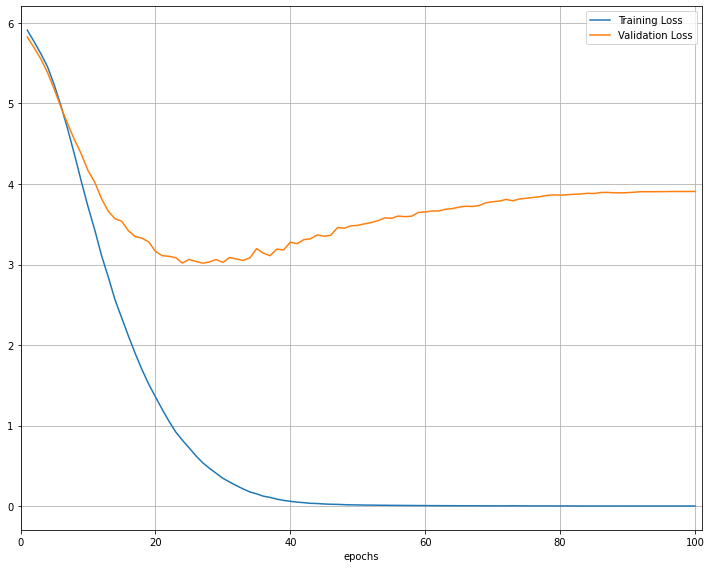

In [92]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [96]:
# 저장하기
state = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': valid_loss,
}
path ="/content/drive/MyDrive/capstone_design/checkpoint.pth"
torch.save(state, path)

# 5. 테스트

#### 테스트 함수 작성

In [77]:
# 7. 새로운 문장 테스트
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids) # forward pass: compute predicted outputs by passing inputs to the model

        test_eval=[]
        for i in out:
            logits = i
            
            softmax_logit = torch.softmax(logits, dim=-1)
            softmax_logit = softmax_logit.squeeze()

            max_index = torch.argmax(softmax_logit).item()
            max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

            print('"', predict_sentence, '"')
            print('카테고리 : ', wellness_dialog_category[max_index][0])
            index = wellness_dialog_category[max_index][0]

            comment_list = wellness_dialog_system[index]
            print('코멘트 후보 : ', comment_list)

            comment_len = len(comment_list) - 1
            comment_index = random.randint(0, comment_len)
            print('코멘트 : ', comment_list[comment_index])

####테스트 실행

In [91]:
predict('이번 일은 없던걸로 넘어가야겠어. 너무 짜증나.')
print('-'*80)
predict('제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요')
print('-'*80)
predict('얼른 끝내고 친구들이랑 놀러가고싶다')
print('-'*80)
predict('나 1등 됐어!')
print('-'*80)
predict('나 학사경고 받았어')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


" 이번 일은 없던걸로 넘어가야겠어. 너무 짜증나. "
카테고리 :  감정/짜증
코멘트 후보 :  ['그런 일이 있었군요. 기분이 많이 나빴겠어요.', '으휴, 제가 대신 혼내주고 싶네요!', '달달한 걸 먹으면 짜증이 달아날 거예요.', '짜증이 날 때 일부러 크게 웃는 것도 좋은 방법인 것 같아요.']
코멘트 :  으휴, 제가 대신 혼내주고 싶네요!
--------------------------------------------------------------------------------
" 제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요 "
카테고리 :  감정/감정조절이상
코멘트 후보 :  ['감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.', '저도 그 기분 이해해요. 많이 힘드시죠?', '그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.']
코멘트 :  그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.
--------------------------------------------------------------------------------
" 얼른 끝내고 친구들이랑 놀러가고싶다 "
카테고리 :  배경/생활
코멘트 후보 :  ['네, 그렇군요.', '아, 그런 일이 있었군요?', '흥미로운 이야기예요. 더 들려주세요.', '당신의 이야기가 더 듣고 싶어요.']
코멘트 :  흥미로운 이야기예요. 더 들려주세요.
--------------------------------------------------------------------------------
" 나 1등 됐어! "
카테고리 :  감정/자신감저하
코멘트 후보 :  ['자신감을 잃으셨군요. 이럴 땐 남과 비교하는 게 좋지 않을 거예요.', '늘 잘할 수는 없어요. 하지만 여태 잘 해왔잖아요.', '어깨를 펴보세요. 자신감이 조금 상승할 거예요.']
코멘트 :  자신감을 잃으셨군요. 이럴 땐 남과 비교하